In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize, sent_tokenize
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

/home/guilalire/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
df = pd.read_csv('../data/dataset.csv', index_col=0)
sample_df = df.sample(2000)

In [3]:
X_list = list(sample_df['text'])
X_strings = " ".join(X_list).lower()
X_sents = sent_tokenize(X_strings)
X_sents = [word_tokenize(s) for s in X_sents]

## Training Word2Vec

In [4]:
model = Word2Vec(sentences=X_sents, vector_size=50, window=5, min_count=5, workers=4)

word_vectors = model.wv
word_vectors.save("word2vec.wordvectors") # Store the words and their trained embeddings
del model

In [5]:
wv = KeyedVectors.load("word2vec.wordvectors", mmap='r')
wv.most_similar('france', topn=10)

[('italy', 0.9211111664772034),
 ('germany', 0.9038487076759338),
 ('netherlands', 0.9002134203910828),
 ('england', 0.8696640133857727),
 ('spain', 0.861041247844696),
 ('berlin', 0.8477269411087036),
 ('1968', 0.8382400870323181),
 ('missouri', 0.8379368185997009),
 ('canada', 0.8378364443778992),
 ('norway', 0.8365739583969116)]

## Documents embedding using Word2Vec

In [6]:
def document_vector(doc, wv):
    """Create document vectors by averaging word vectors."""
    words = word_tokenize(doc)
    word_vectors = np.array([wv[word] for word in words if word in wv])
    
    if len(word_vectors) == 0:
        return np.zeros(wv.vector_size)
    return np.mean(word_vectors, axis=0)

In [7]:
document_vector(X_list[5], wv)

array([-0.4411616 ,  0.54499143, -0.5396647 , -0.0224039 ,  0.1864318 ,
       -0.18302679,  0.5863867 ,  1.0291632 , -1.0734847 , -0.07499337,
        0.16755703, -0.17857999, -0.0818869 , -0.14882287, -0.2824358 ,
        0.1125184 ,  0.6586149 ,  0.53604466, -0.8022688 , -0.6398376 ,
        0.3219006 ,  0.53664345,  0.2650873 , -0.09714815, -0.25252908,
        0.2747682 ,  0.32834554,  1.0919352 , -0.46752653, -0.51308477,
       -0.8194258 ,  0.03528635,  0.01800369, -0.1850748 , -0.77035344,
       -0.20563833,  0.74557763, -0.11127241, -0.57606953, -0.17580673,
        0.3313268 , -0.17422897,  0.08518059, -0.02842501,  0.86685944,
        0.25710127, -0.22858654, -0.544703  ,  0.42187557, -0.08347051],
      dtype=float32)

## Logistic Regression using Word2Vec

In [34]:
X = sample_df['text']
y = sample_df['category']

X = np.array([document_vector(text, wv) for text in X])
#X = np.array([document_vector(text, pretrained_wv) for text in X])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

print(f"Features dimension: {X_train.shape}")

Features dimension: (1600, 50)


In [35]:
model = LogisticRegression(random_state=42, solver='liblinear', penalty='l2', C=10, max_iter=1000, class_weight='balanced')

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

      actors       0.61      0.70      0.65        20
     animals       0.58      0.50      0.54        22
         art       0.55      0.69      0.61        16
       books       0.75      0.64      0.69        33
      events       0.35      0.53      0.42        15
       films       0.75      0.95      0.84        19
     finance       0.25      0.29      0.27         7
        food       0.29      0.11      0.15        19
   geography       0.79      0.68      0.73        28
    industry       0.47      0.53      0.50        15
       music       0.95      1.00      0.97        19
      plants       0.72      0.81      0.76        26
 politicians       0.60      0.90      0.72        20
    politics       0.67      0.44      0.53        18
     science       0.63      0.55      0.59        22
     singers       0.73      0.66      0.69        29
      sports       0.29      0.38      0.33        13
 vi

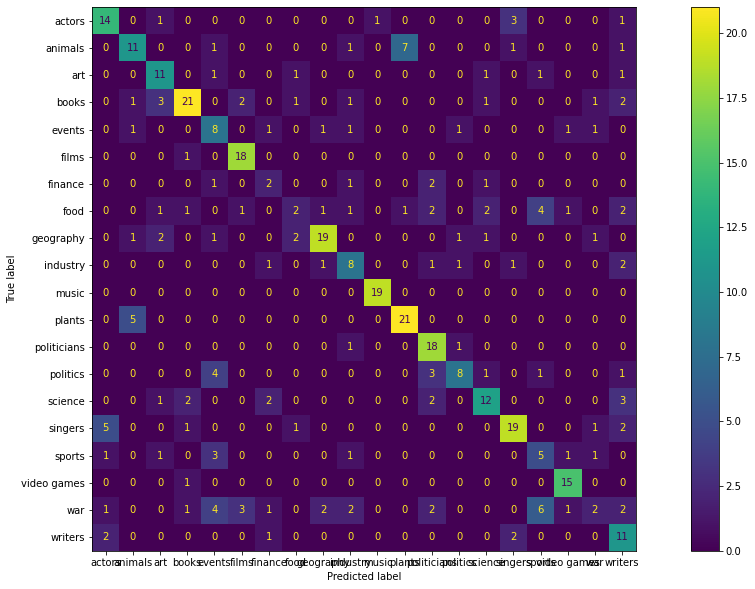

In [36]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=model.classes_)
fig, ax = plt.subplots(figsize=(20, 10))
disp.plot(ax=ax)
plt.show()

## Logistic Regression using TF-IDF

In [37]:
X = sample_df['text']
y = sample_df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

In [38]:
model = make_pipeline(CountVectorizer(tokenizer=word_tokenize, ngram_range=(1,1)),
                      TfidfTransformer(),
                      LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear', penalty='l1', C=100, max_iter=1000))

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

      actors       0.89      0.85      0.87        20
     animals       0.91      0.91      0.91        22
         art       0.93      0.81      0.87        16
       books       0.84      0.82      0.83        33
      events       0.59      0.87      0.70        15
       films       0.86      1.00      0.93        19
     finance       1.00      0.57      0.73         7
        food       0.83      0.79      0.81        19
   geography       0.88      0.79      0.83        28
    industry       0.91      0.67      0.77        15
       music       0.95      1.00      0.97        19
      plants       0.96      0.96      0.96        26
 politicians       0.74      0.85      0.79        20
    politics       0.68      0.72      0.70        18
     science       0.74      0.91      0.82        22
     singers       0.83      1.00      0.91        29
      sports       0.54      0.54      0.54        13
 vi

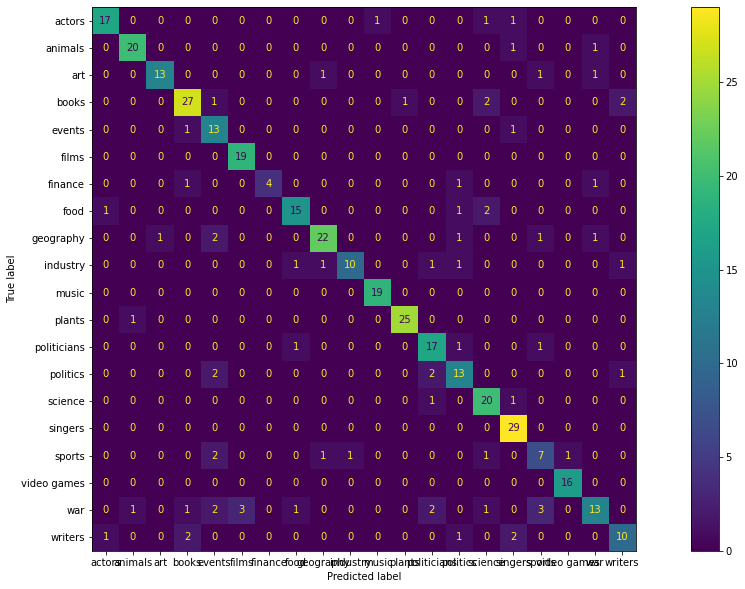

In [39]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=model.classes_)
fig, ax = plt.subplots(figsize=(20, 10))
disp.plot(ax=ax)
plt.show()

## GridSearch to find the best hyperparameters for Logistic Regression using Word2Vec

In [28]:
X = sample_df['text']
y = sample_df['category']

X = np.array([document_vector(text, wv) for text in X])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')

In [30]:
param_grid = [
    {'solver': ['liblinear'],
      'penalty': ['l1', 'l2'],
      'C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'solver': ['lbfgs'],
      'penalty': ['l2'],
      'C': [0.001, 0.01, 0.1, 1, 10, 100]}
    ]

grid_search = GridSearchCV(model, param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test set score:", test_score)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/home/guilalire/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/guilalire/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

Best parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation score: 0.57125
Test set score: 0.61


## GridSearch to find the best hyperparameters for Logistic Regression using TF-IDF

In [32]:
X = sample_df['text']
y = sample_df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

model = make_pipeline(CountVectorizer(tokenizer=word_tokenize, ngram_range=(1,1)),
                      TfidfTransformer(),
                      LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000))

In [33]:
param_grid = [
    {'logisticregression__solver': ['liblinear'],
      'logisticregression__penalty': ['l1', 'l2'],
      'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'logisticregression__solver': ['lbfgs'],
      'logisticregression__penalty': ['l2'],
      'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100]}
    ]

grid_search = GridSearchCV(model, param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test set score:", test_score)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'logisticregression__C': 100, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
Best cross-validation score: 0.795625
Test set score: 0.8225
